In [ ]:
# Code for the Book: International Stock Picking A.I. INVESTOR: A Guide to Build.
# Website: ai-investor.net
# Code needs am "All-In-One" subscription from the (presumably) nice people at https://eodhistoricaldata.com/. 
# Check the book text to see if they have changed their service since mid-2021.

# Damon Lee 2021

# Feel free to fork this code for others to see what can be done with it.

In [ ]:
myToken = 'ABC123.XXXXXX.84098767' # Own token from EODHistoricalData

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Set the plotting DPI settings to be a bit higher.
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [2]:
import requests
from io import StringIO # read string as file for pandas

def get_eod_data(startDate, endDate, symbol='MCD.US', 
                 api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX', session=None):
    '''
    Make API call to EODHistoricalData to get financial price series for a ticker.
    Returns a DataFrame.
    
    If an error is present, the StockWithIssues.txt will have an entry, and the
    returned price series will just be 1's as if uninvested.
    '''
    if session is None:
        session = requests.Session()
    url = 'https://eodhistoricaldata.com/api/eod/%s' % symbol
    params = {'api_token': api_token, 'from':startDate, 'to':endDate}
    r = session.get(url, params=params)
    
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), 
                         skipfooter=1, parse_dates=[0], 
                         engine='python', index_col=0)
        
        if df.shape[0] == 0: # in case of error return constant price.
            df=pd.DataFrame(index=pd.date_range(start=startDate, end=endDate), 
                            columns=['Adjusted_close'])
            df['Adjusted_close']=1
        return df
    else:
        # We don't want the backtest to stop if we reach an error
        # We will force the ticker to be equivalent to being uninvested
        with open("StockWithIssues.txt", "a") as myfile:
            myfile.write(symbol+'\n')
            myfile.close()
        tempDf=pd.DataFrame(index=pd.date_range(start=startDate, end=endDate), columns=['Adjusted_close'])
        tempDf['Adjusted_close']=1
        return tempDf
        
#test = get_eod_data('2016-01-01','2016-05-30', symbol='MCD.US', api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX')
#test = get_eod_data('2016-01-01','2016-05-30', symbol='LPPF.JK', api_token=myToken)

def getPortfolioRelativeTimeSeries(stockRet):
    '''
    Normalise a dataframe of stock prices of a portfolio over time.
    As a column for the overall portfolio value change.
    '''
    stockRetRel = stockRet.copy()
    for key in stockRetRel.keys():
        stockRetRel[key]=stockRetRel[key]/stockRetRel[key][0]
    stockRetRel["Portfolio"] = stockRetRel.sum(axis=1)/(stockRetRel.keys().shape[0])
    return stockRetRel

# Two Stock Manual Diversification Example

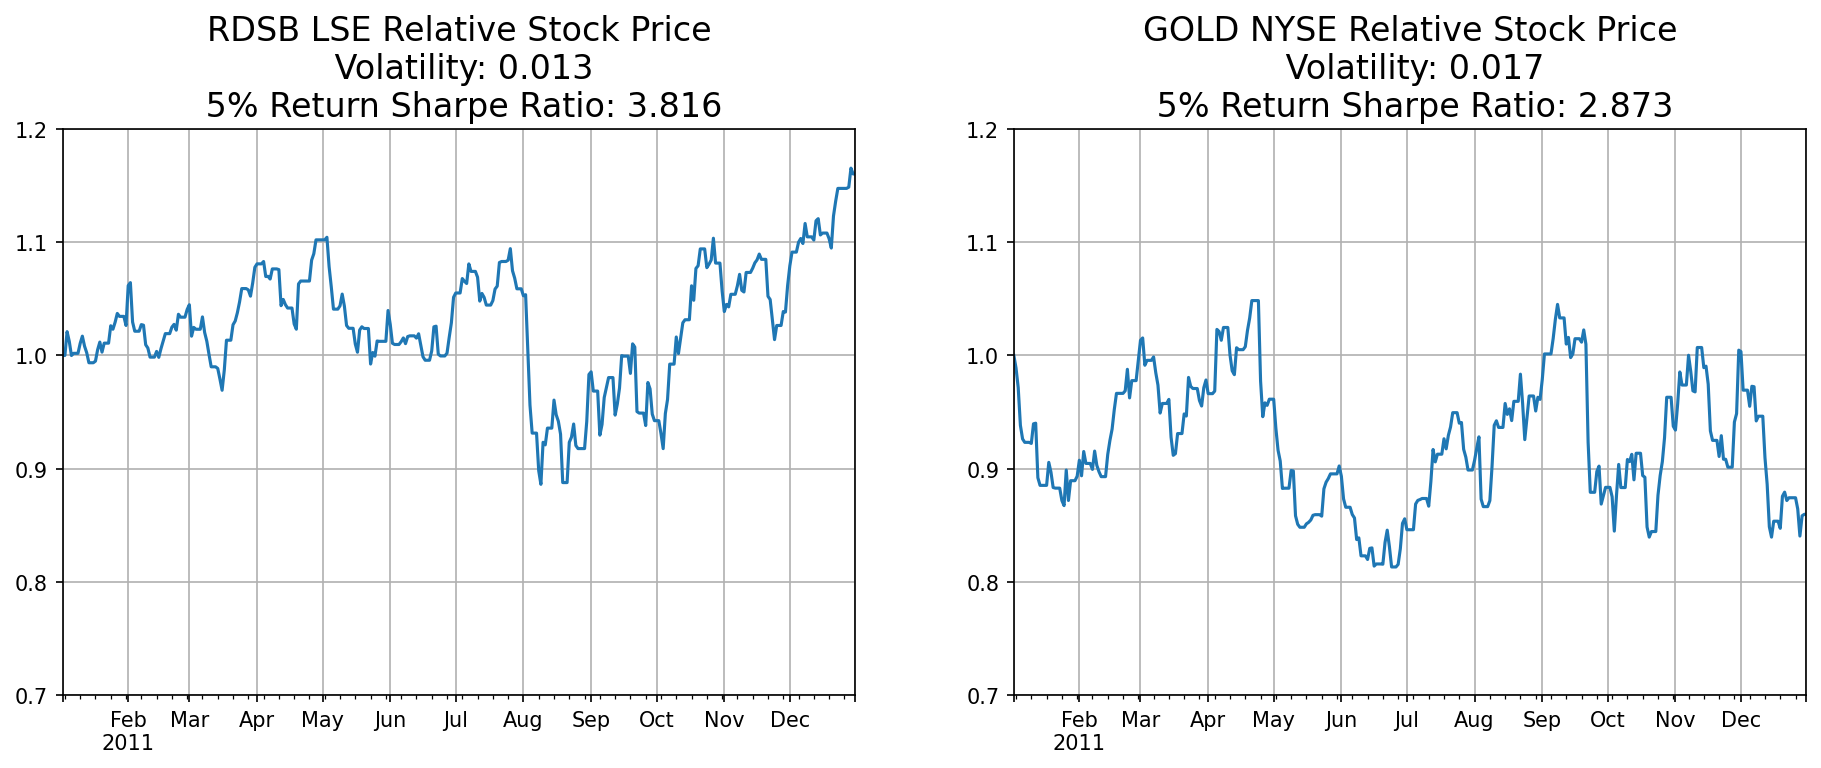

In [3]:
rdsb = get_eod_data('2009-01-01','2020-01-01', 
                    symbol='RDSB.LSE', 
                    api_token=myToken)

gold = get_eod_data('2009-01-01','2020-01-01', 
                    symbol='GOLD.US', 
                    api_token=myToken)

portfolio = pd.DataFrame(index=pd.date_range(start='2009-01-01', 
                                             end='2020-01-01'))

portfolio['rdsb']=rdsb['Adjusted_close']
portfolio['gold']=gold['Adjusted_close']
portfolio = portfolio.ffill().bfill()

assets = getPortfolioRelativeTimeSeries(portfolio).drop(columns=['Portfolio'])

def getVol(series):
    '''
    Get the volatility of series
    '''
    return np.log(series/series.shift(-1)).std()

mask = (assets.index>'2011-01-01') & (assets.index<'2012-01-01')
#mask = (assets.index>'2012-01-01') & (assets.index<'2013-01-01')

asset1 = assets['rdsb'][mask]/assets['rdsb'][mask].iloc[0]
asset2 = assets['gold'][mask]/assets['gold'][mask].iloc[0]

title1 = 'RDSB LSE Relative Stock Price\n Volatility: ' + \
            str(round(getVol(asset1),3))+'\n 5% Return Sharpe Ratio: ' + \
            str(round(0.05/getVol(asset1),3))

title2 = 'GOLD NYSE Relative Stock Price\n Volatility: ' + \
            str(round(getVol(asset2),3))+'\n 5% Return Sharpe Ratio: ' + \
            str(round(0.05/getVol(asset2),3))

plt.figure(figsize=(15,5));
plt.subplot(1,2,1);
asset1.plot();
plt.title(title1, fontsize=16)
plt.ylim([0.7,1.2])
plt.grid()
plt.subplot(1,2,2);
asset2.plot();
plt.title(title2, fontsize=16)
plt.ylim([0.7,1.2])
plt.grid()

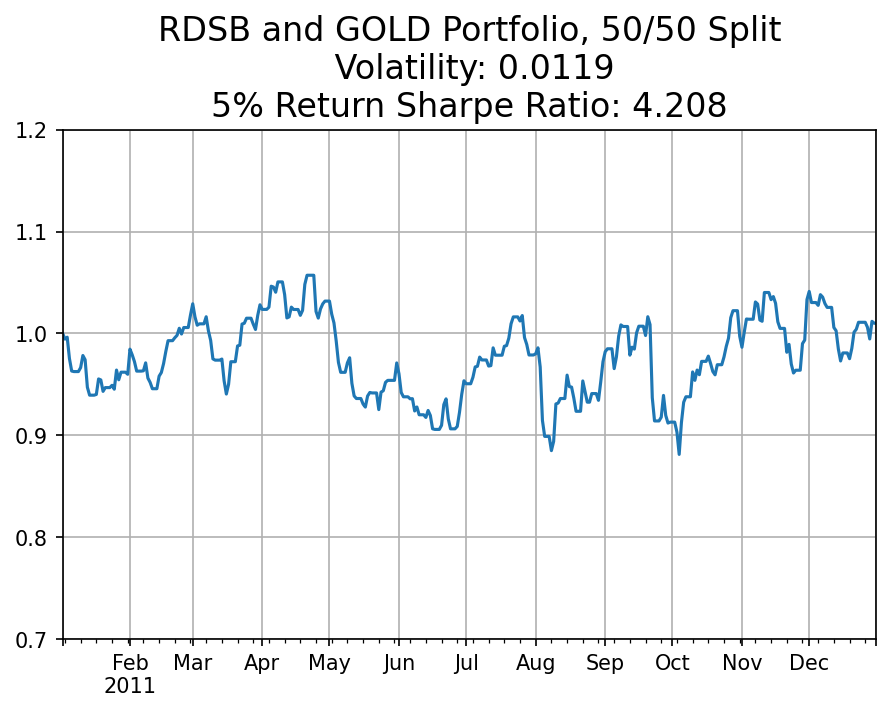

In [4]:
splitPortfolio = ((0.5*asset1 + 0.5*asset2))
splitPortfolio.plot()
plt.ylim([0.7,1.2])
plt.grid()
title3 = 'RDSB and GOLD Portfolio, 50/50 Split\n Volatility: ' + \
            str(round(getVol(splitPortfolio),4)) + \
            '\n5% Return Sharpe Ratio: ' + \
            str(round(0.05/getVol(splitPortfolio),3))
plt.title(title3, fontsize=16);

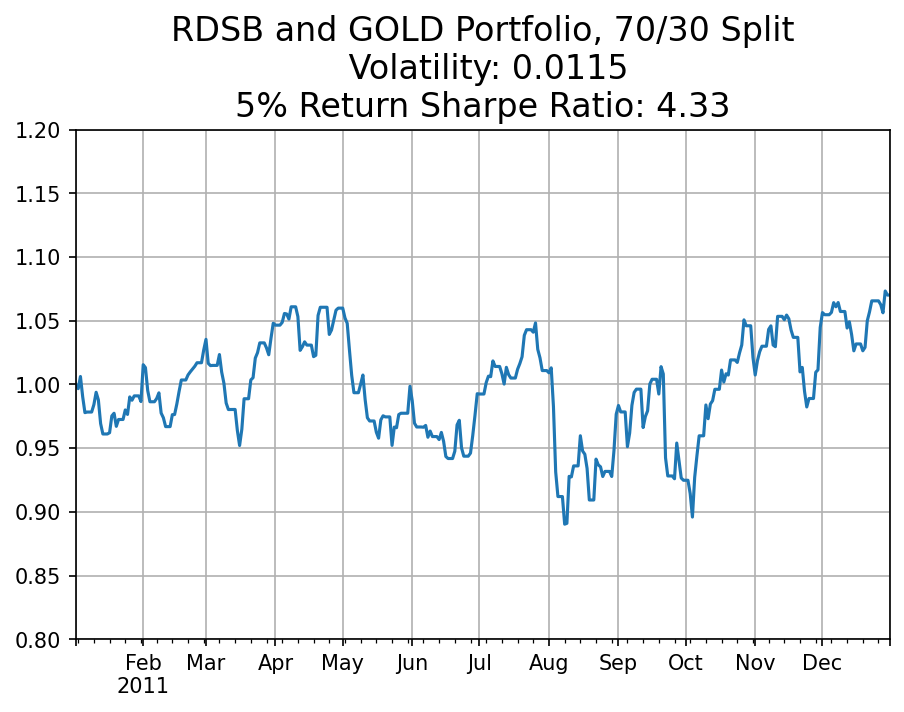

In [5]:
splitPortfolio = ((0.7*asset1 + 0.3*asset2))
splitPortfolio.plot()
plt.ylim([0.8,1.2])
plt.grid()
title3 = 'RDSB and GOLD Portfolio, 70/30 Split\n Volatility: ' + \
            str(round(getVol(splitPortfolio),4)) + \
            '\n5% Return Sharpe Ratio: ' + \
            str(round(0.05/getVol(splitPortfolio),3))
plt.title(title3, fontsize=16);

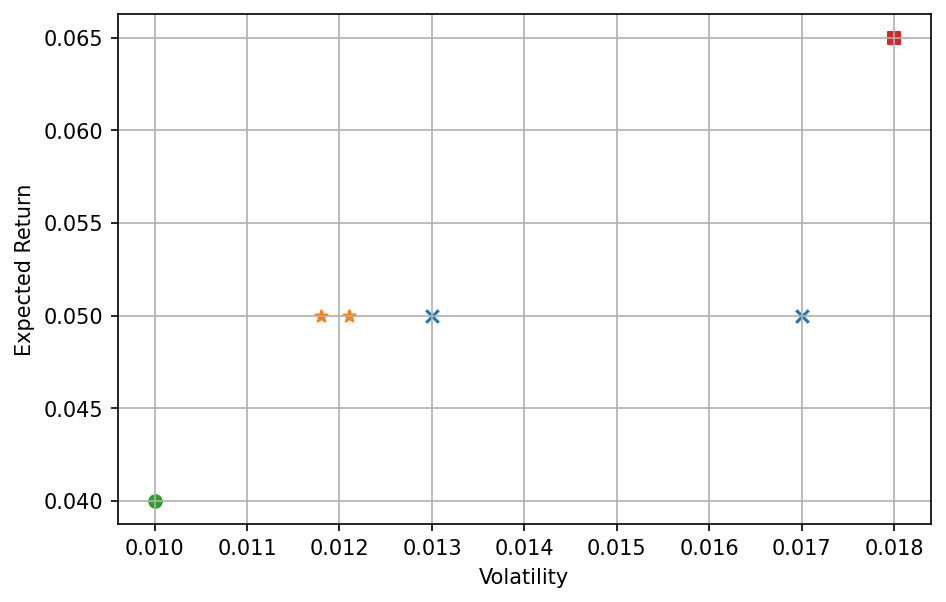

In [6]:
volatilityOfUnderlyingStocks = [0.013, 0.017]
returnsOfUnderlyingStocks = [0.05, 0.05]

volatilityOfPortfolios = [0.0121, 0.0118]
returnsOfPortfolios = [0.05, 0.05]

plt.scatter(volatilityOfUnderlyingStocks, returnsOfUnderlyingStocks, marker='x')
plt.scatter(volatilityOfPortfolios, returnsOfPortfolios, marker='*')
plt.scatter(0.01, 0.04, marker='o') # Hypothetical Company
plt.scatter(0.018, 0.065, marker='s') # Hypothetical Company
plt.grid()
plt.xlabel('Volatility');
plt.ylabel('Expected Return');

## Our MPT didn't work too well one year into the future.
The correlation needs to hold, and the prediction for return needs to be right.

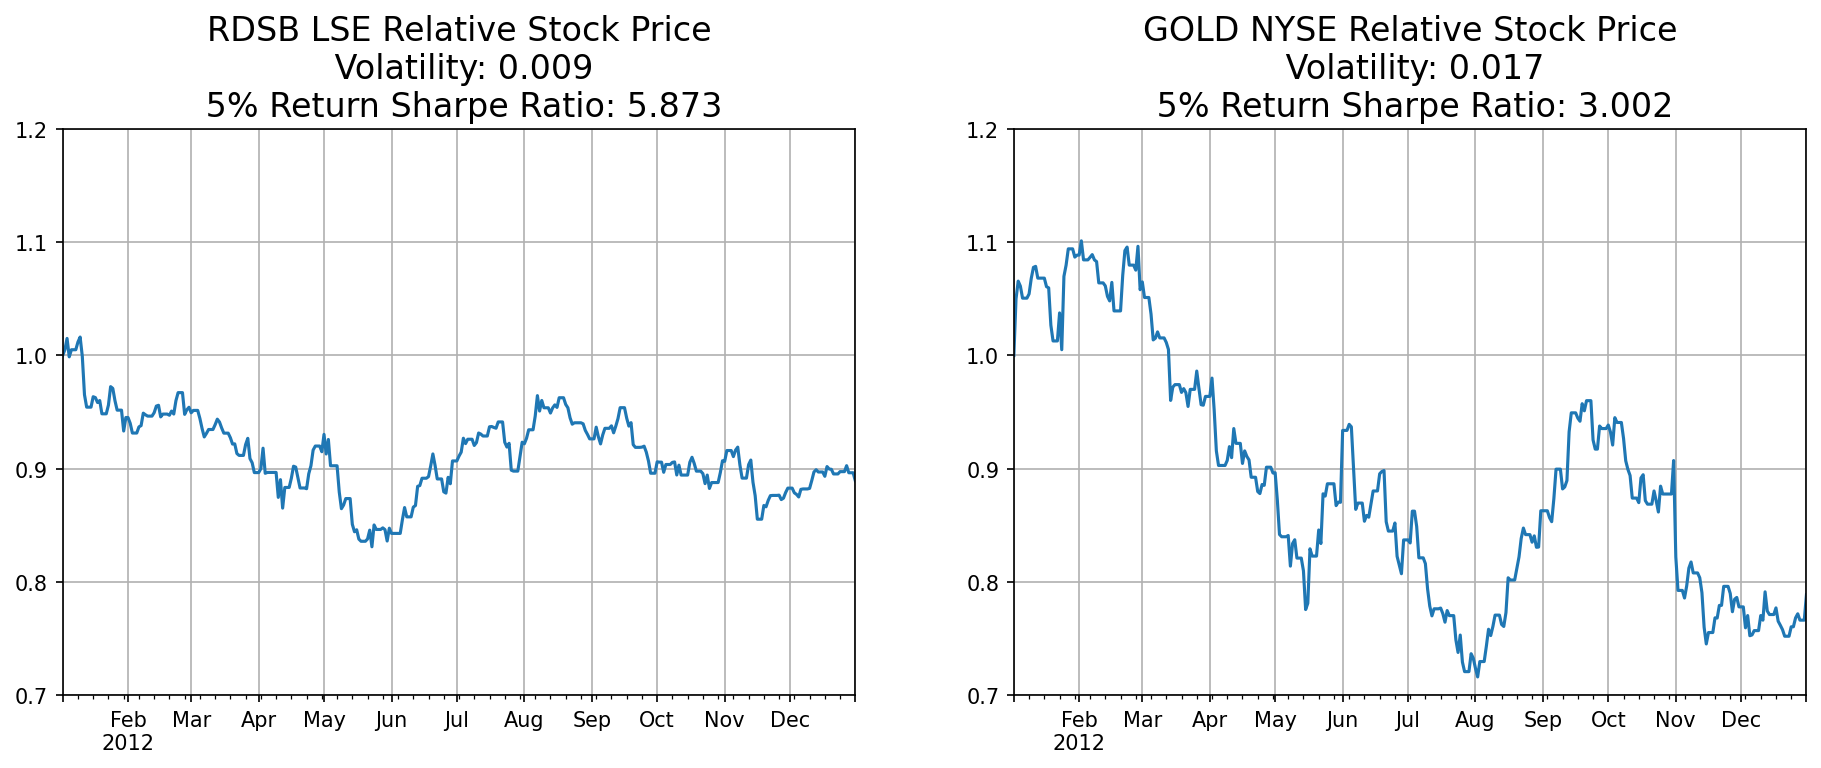

In [7]:
#mask = (assets.index>'2011-01-01') & (assets.index<'2012-01-01')
mask = (assets.index>'2012-01-01') & (assets.index<'2013-01-01')

asset1 = assets['rdsb'][mask]/assets['rdsb'][mask].iloc[0]
asset2 = assets['gold'][mask]/assets['gold'][mask].iloc[0]

title1 = 'RDSB LSE Relative Stock Price\n Volatility: ' + \
            str(round(getVol(asset1),3))+'\n 5% Return Sharpe Ratio: ' + \
            str(round(0.05/getVol(asset1),3))

title2 = 'GOLD NYSE Relative Stock Price\n Volatility: ' + \
            str(round(getVol(asset2),3))+'\n 5% Return Sharpe Ratio: ' + \
            str(round(0.05/getVol(asset2),3))


plt.figure(figsize=(15,5));
plt.subplot(1,2,1);
asset1.plot();
plt.title(title1, fontsize=16)
plt.ylim([0.7,1.2])
plt.grid()
plt.subplot(1,2,2);
asset2.plot();
plt.title(title2, fontsize=16)
plt.ylim([0.7,1.2])
plt.grid()

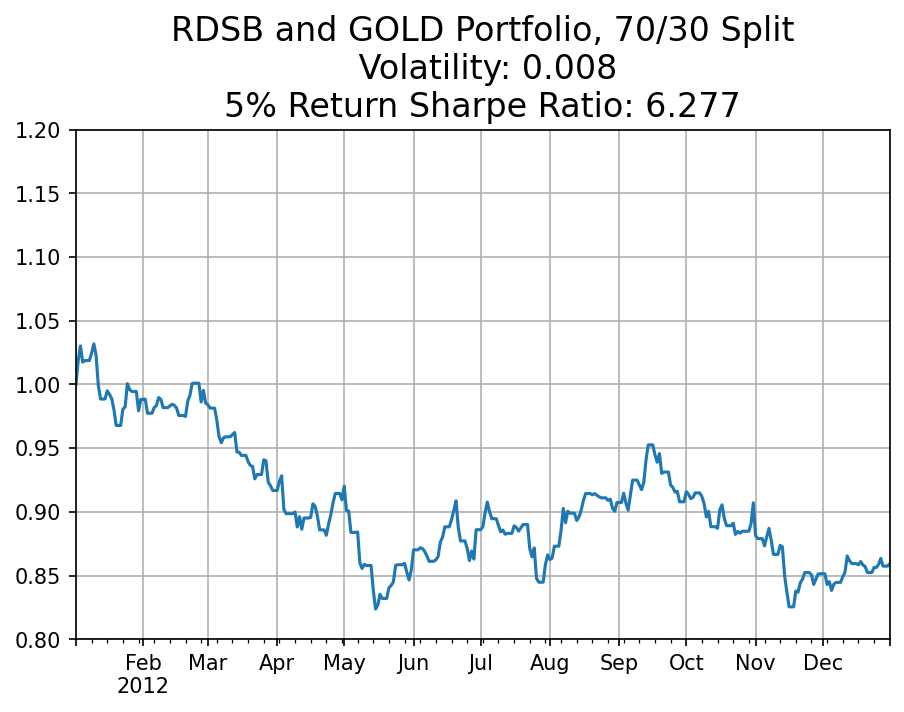

In [8]:
splitPortfolio = ((0.7*asset1 + 0.3*asset2))
splitPortfolio.plot()
plt.ylim([0.8,1.2])
plt.grid()
title3 = 'RDSB and GOLD Portfolio, 70/30 Split\n Volatility: ' + \
            str(round(getVol(splitPortfolio),4)) + \
            '\n5% Return Sharpe Ratio: ' + \
            str(round(0.05/getVol(splitPortfolio),3))
plt.title(title3, fontsize=16);

# Portfolio Volatility From The Covariance Matrix

In [9]:
twoStockPortfolio = pd.concat([asset1, asset2], axis=1)
twoStockPortfolio.head()

,rdsb,gold
2012-01-02,1.000000,1.000000
2012-01-03,1.005094,1.049943
2012-01-04,1.015046,1.065634
2012-01-05,0.998778,1.061216
2012-01-06,1.005061,1.050607


array([[<AxesSubplot:title={'center':'rdsb'}>,
        <AxesSubplot:title={'center':'gold'}>]], dtype=object)

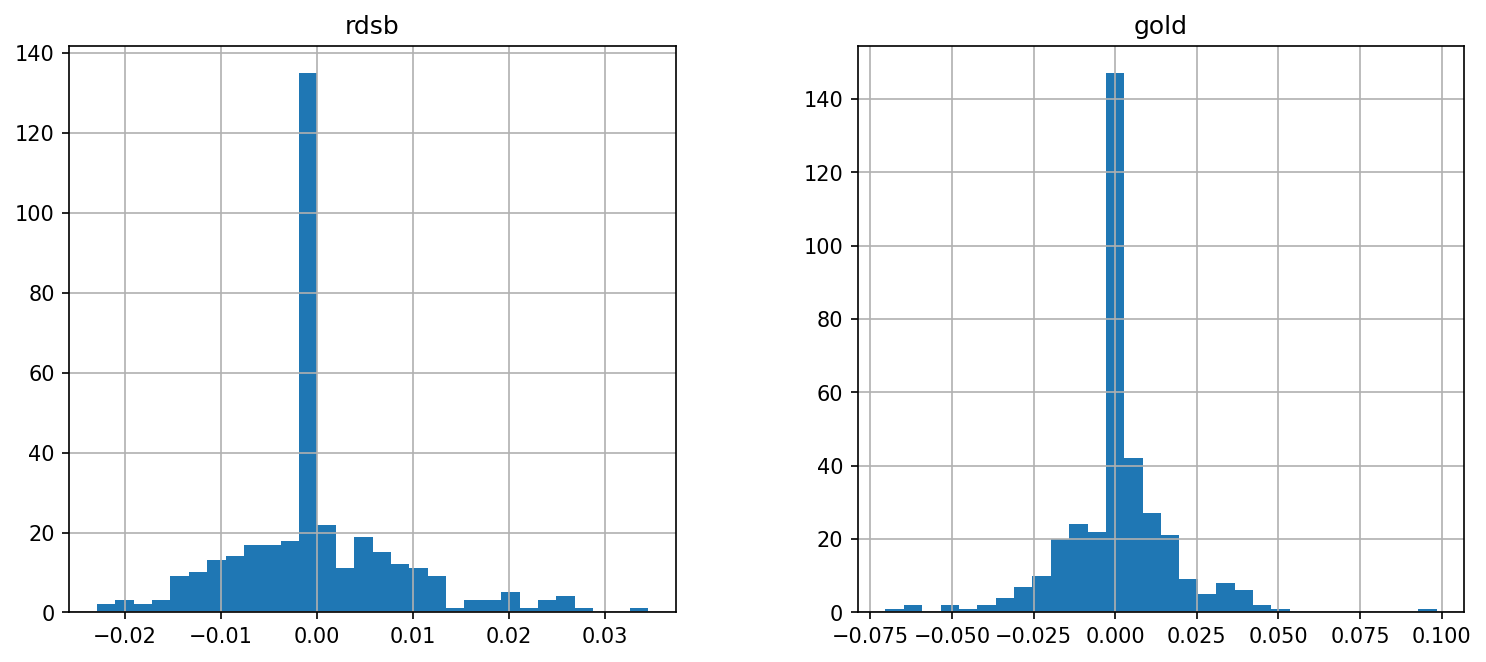

In [10]:
np.log(twoStockPortfolio/twoStockPortfolio.shift(-1)).hist(figsize=(12,5), bins=30)

In [11]:
np.log(twoStockPortfolio/twoStockPortfolio.shift(-1)).cov()

,rdsb,gold
rdsb,0.000072,0.000009
gold,0.000009,0.000277


In [12]:
weights = [0.7, 0.3]

In [13]:
np.sqrt(np.dot(np.dot(np.array(np.log(twoStockPortfolio/twoStockPortfolio.shift(-1)).cov()),weights),weights)) 
# Similar to the 0.0118 value earlier

0.00801806940506484

### Example Correlation Matrix for Anti-Correlated Securities

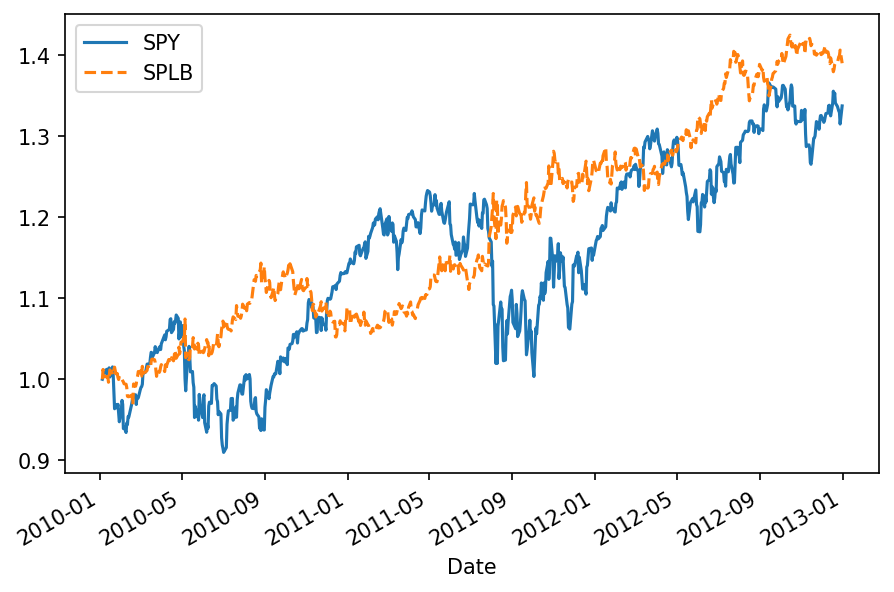

In [14]:
SPY = get_eod_data('2010-01-01','2013-01-01', 
                    symbol='SPY.US', 
                    api_token=myToken)['Adjusted_close'].ffill().bfill()
SPLB = get_eod_data('2010-01-01','2013-01-01', 
                    symbol='SPLB.US', 
                    api_token=myToken)['Adjusted_close'].ffill().bfill()

spyVsBonds = pd.concat([SPY, SPLB], keys=['SPY', 'SPLB'], axis=1)
spyVsBonds = getPortfolioRelativeTimeSeries(spyVsBonds).drop(columns=['Portfolio'])
spyVsBonds.plot(style=['-','--']);

In [15]:
np.log(spyVsBonds/spyVsBonds.shift(-1)).corr()

,SPY,SPLB
SPY,1.000000,-0.312962
SPLB,-0.312962,1.000000


### Example Correlation Matrix for Correlated Securities

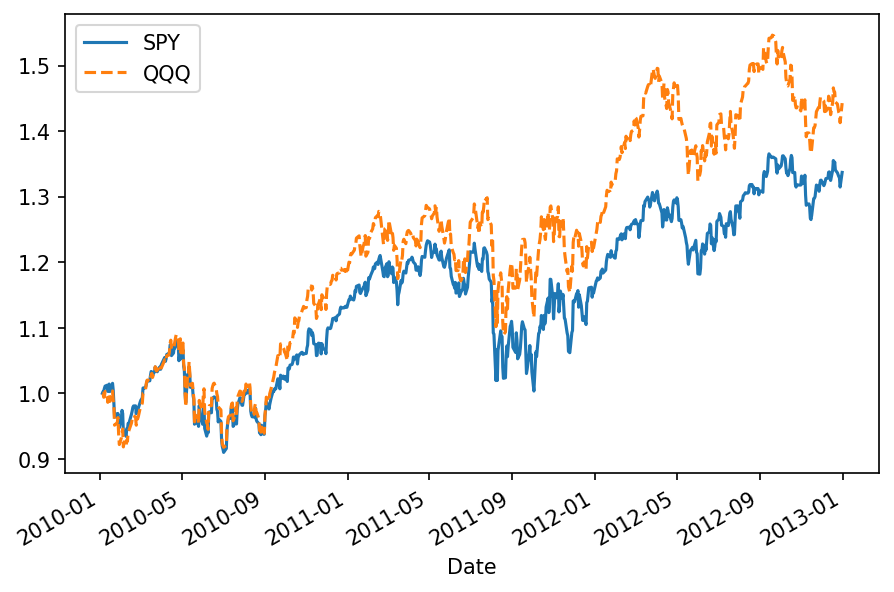

In [16]:
SPY = get_eod_data('2010-01-01','2013-01-01', 
                    symbol='SPY.US', 
                    api_token=myToken)['Adjusted_close'].ffill().bfill()
QQQ = get_eod_data('2010-01-01','2013-01-01', 
                    symbol='QQQ.US', 
                    api_token=myToken)['Adjusted_close'].ffill().bfill()

spyVsNasdaq = pd.concat([SPY, QQQ], keys=['SPY', 'QQQ'], axis=1)
spyVsNasdaq = getPortfolioRelativeTimeSeries(spyVsNasdaq).drop(columns=['Portfolio'])
spyVsNasdaq.plot(style=['-','--']);

In [17]:
np.log(spyVsNasdaq/spyVsNasdaq.shift(-1)).corr()

,SPY,QQQ
SPY,1.000000,0.938837
QQQ,0.938837,1.000000


### Example Finding Volatility from Covariance Matrix

In [18]:
def calcPortfolioVar(portfolio, weights=None):
    '''
    Input is portfolio price history DataFrame.
    Calculate the variance of the portfolio given the asset weighting.
    Assumes equal asset weighting if no weighting given.
    '''
    if weights is None:
        weights = [1 / portfolio.keys().size] * portfolio.keys().size
    
    # Use the dot product matrix multiplication
    var = np.dot(np.dot(
            np.array(np.log(portfolio/portfolio.shift(-1)).cov()),
                        weights), weights)
    return var

In [19]:
np.sqrt(calcPortfolioVar(pd.concat([asset1, asset2], axis=1), weights=[0.7, 0.3]))

0.00801806940506484

### Try a Hypothetical Portfolio with 3 Stocks

In [20]:
amd = get_eod_data('2009-01-01','2020-01-01', symbol='AMD.US', api_token=myToken)
gaw = get_eod_data('2009-01-01','2020-01-01', symbol='GAW.LSE', api_token=myToken)
snr = get_eod_data('2009-01-01','2020-01-01', symbol='SNR.LSE', api_token=myToken)

portfolio = pd.DataFrame(index=pd.date_range(start='2015-01-01', end='2020-01-01'))

portfolio['amd']=amd['Adjusted_close']
portfolio['gaw']=gaw['Adjusted_close']
portfolio['snr']=snr['Adjusted_close']

portfolio = portfolio.ffill().bfill()
assets = getPortfolioRelativeTimeSeries(portfolio)#.drop(columns=['Portfolio'])
combinedPortfolio=assets['Portfolio']
assets.drop(columns=['Portfolio'], inplace=True)

assets.tail()

,amd,gaw,snr
2019-12-28,17.167286,12.158098,0.589918
2019-12-29,17.167286,12.158098,0.589918
2019-12-30,16.921933,12.237889,0.581340
2019-12-31,17.048327,12.178046,0.570452
2020-01-01,17.048327,12.178046,0.570452


In [21]:
np.log(assets/assets.shift(-1)).cov()

,amd,gaw,snr
amd,0.001070,0.000057,0.000064
gaw,0.000057,0.000296,0.000039
snr,0.000064,0.000039,0.000254


In [22]:
# Using the Covariance Matrix
weights = [1/3, 1/3, 1/3]
np.sqrt(np.dot(np.dot(np.array(np.log(assets/assets.shift(-1)).cov()),weights),weights))

0.014682045063850287

In [23]:
# Working it out with arithmetic
(np.log(assets/assets.shift(-1)).sum(axis=1)/3).std()

0.014678038400903313

### Answers Can Differ Slightly.
Because of order of averaging and division. In the end of the day it probably doesn't matter which is used.

In [24]:
((assets/assets.shift(-1)-1).sum(axis=1)/3).std() # different

0.014565302926334522

In [25]:
(combinedPortfolio/combinedPortfolio.shift(-1)-1).std() # different, check getPortfolioRelativeTimeSeries()

0.01851974107311919

# Random Selection to See the Markowitz Bullet

In [26]:
gaw = get_eod_data('2009-01-01','2020-01-01', symbol='GAW.LSE', api_token=myToken)

In [27]:
snr = get_eod_data('2009-01-01','2020-01-01', symbol='SNR.LSE', api_token=myToken)

In [28]:
qq = get_eod_data('2009-01-01','2020-01-01', symbol='QQ.LSE', api_token=myToken)

In [29]:
amd = get_eod_data('2009-01-01','2020-01-01', symbol='AMD.US', api_token=myToken)

In [30]:
mcd = get_eod_data('2009-01-01','2020-01-01', symbol='MCD.US', api_token=myToken)

In [31]:
mat = get_eod_data('2009-01-01','2020-01-01', symbol='MAT.US', api_token=myToken)

In [32]:
lmt = get_eod_data('2009-01-01','2020-01-01', symbol='LMT.US', api_token=myToken)

In [33]:
mas = get_eod_data('2009-01-01','2020-01-01', symbol='MAS.US', api_token=myToken)

In [34]:
portfolio = pd.DataFrame(index=pd.date_range(start='2009-01-01', end='2020-01-01'))

portfolio['snr']=snr['Adjusted_close']
portfolio['qq']=qq['Adjusted_close']
portfolio['amd']=amd['Adjusted_close']
portfolio['mcd']=mcd['Adjusted_close']
portfolio['mat']=mat['Adjusted_close']
portfolio['lmt']=lmt['Adjusted_close']
portfolio['mas']=mas['Adjusted_close']

portfolio = portfolio.ffill().bfill()
assets = getPortfolioRelativeTimeSeries(portfolio).drop(columns=['Portfolio'])
assets

,snr,qq,amd,mcd,mat,lmt,mas
2009-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2009-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2009-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2009-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2009-01-05,0.976058,0.989081,1.121849,0.997018,0.981994,0.980129,1.031665
...,...,...,...,...,...,...,...
2019-12-28,4.635601,2.358111,19.403361,4.336474,1.198676,6.623831,5.954814
2019-12-29,4.635601,2.358111,19.403361,4.336474,1.198676,6.623831,5.954814
2019-12-30,4.568192,2.325754,19.126050,4.308902,1.187384,6.595223,5.949874
2019-12-31,4.482635,2.315400,19.268908,4.324218,1.176961,6.552814,5.937491


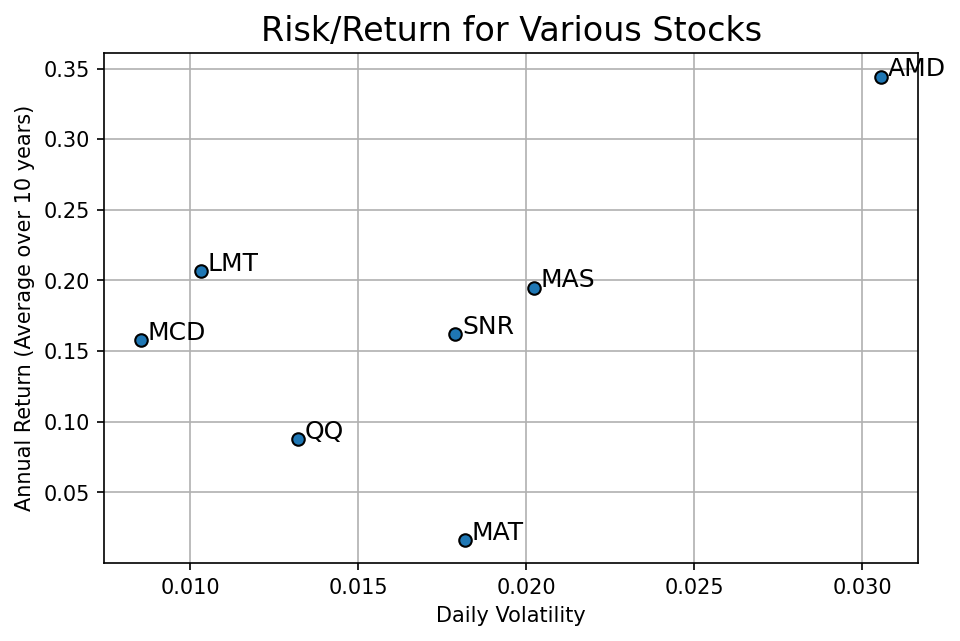

In [35]:
plt.title('Risk/Return for Various Stocks', fontsize=16)
plt.ylabel('Annual Return (Average over 10 years)')
plt.xlabel('Daily Volatility')
plt.grid()
volatility = getVol(assets)
returns = (assets.iloc[-1] ** (1/10) - 1)
plt.scatter(volatility, returns, edgecolors='k')

for i in range(assets.shape[1]):
    x = volatility[i]
    y = returns[i]
    plt.text(x + 2e-4, y + 2e-4 , assets.keys()[i].upper(), fontsize=12)

In [36]:
np.sqrt(calcPortfolioVar(assets))

0.010097952111594016

In [250]:
from numpy import random
riskReturnAndPortfolios = pd.DataFrame()

for i in range(0, 50000):
    #Portfolio Weights
    w = random.rand(len(assets.keys()))
    portfolioWeights = w/np.sum(w)
    #Return
    portfolioReturn = np.dot( (assets.iloc[-1] ** (1/10) - 1) , 
                             portfolioWeights)
    #Vol
    portfolioVolatility = np.sqrt(calcPortfolioVar(assets, 
                                                   weights=portfolioWeights))
    
    riskReturnAndPortfolios = \
    riskReturnAndPortfolios.append({'portfolioWeights':portfolioWeights,
                                    'portfolioReturn':portfolioReturn,
                                    'portfolioVolatility':portfolioVolatility},
                                   ignore_index=True)

riskReturnAndPortfolios.head()

,portfolioReturn,portfolioVolatility,portfolioWeights
0,0.162214,0.008439,"[0.10021660548118343, 0.15898049409359205, 0.0..."
1,0.168743,0.008158,"[0.22929198128641642, 0.06533064738273728, 0.0..."
2,0.162181,0.012908,"[0.022516520262937274, 0.23422634971927855, 0...."
3,0.214146,0.013757,"[0.1446660141699234, 0.24107079460502742, 0.34..."
4,0.188764,0.011371,"[0.0917929726144394, 0.22788601689596452, 0.20..."


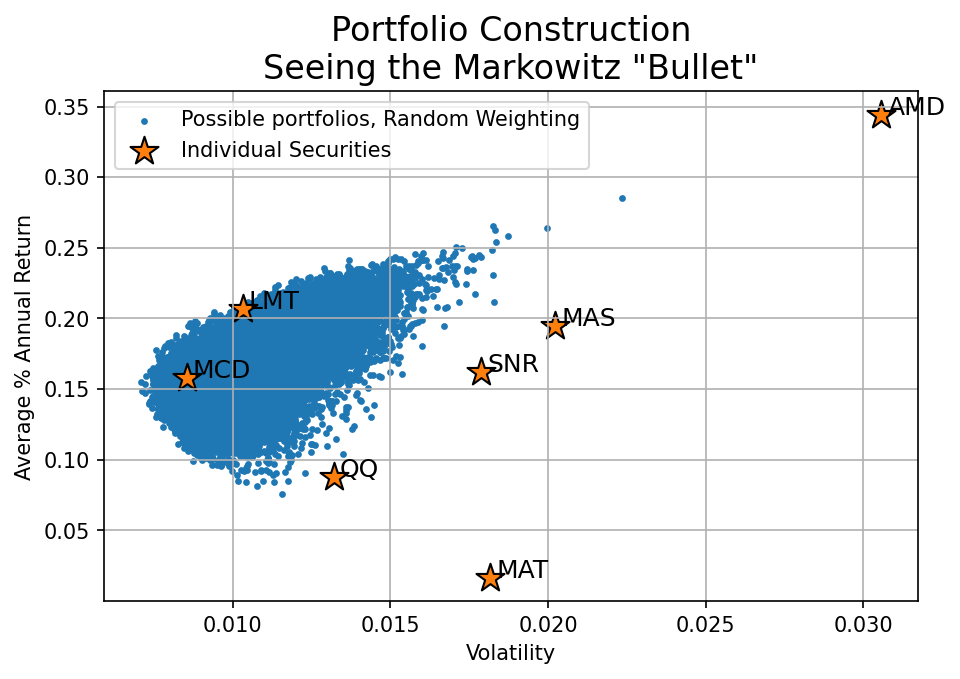

In [262]:
plt.scatter(riskReturnAndPortfolios['portfolioVolatility'], 
            riskReturnAndPortfolios['portfolioReturn'], s=5)
plt.scatter(getVol(assets), assets.iloc[-1] ** (1/10)-1, marker='*', s=200, edgecolors='k')
plt.xlabel('Volatility');
plt.ylabel('Average % Annual Return');
plt.title('Portfolio Construction\nSeeing the Markowitz "Bullet"', fontsize=16);
plt.grid();
plt.legend(['Possible portfolios, Random Weighting', 'Individual Securities']);

for i in range(assets.shape[1]):
    x = volatility[i]
    y = returns[i]
    plt.text(x + 2e-4, y + 2e-4 , assets.keys()[i].upper(), fontsize=12)

The best portfolio we could find through random selection
has a return of:  0.178 %
and a Volatility of:  0.008


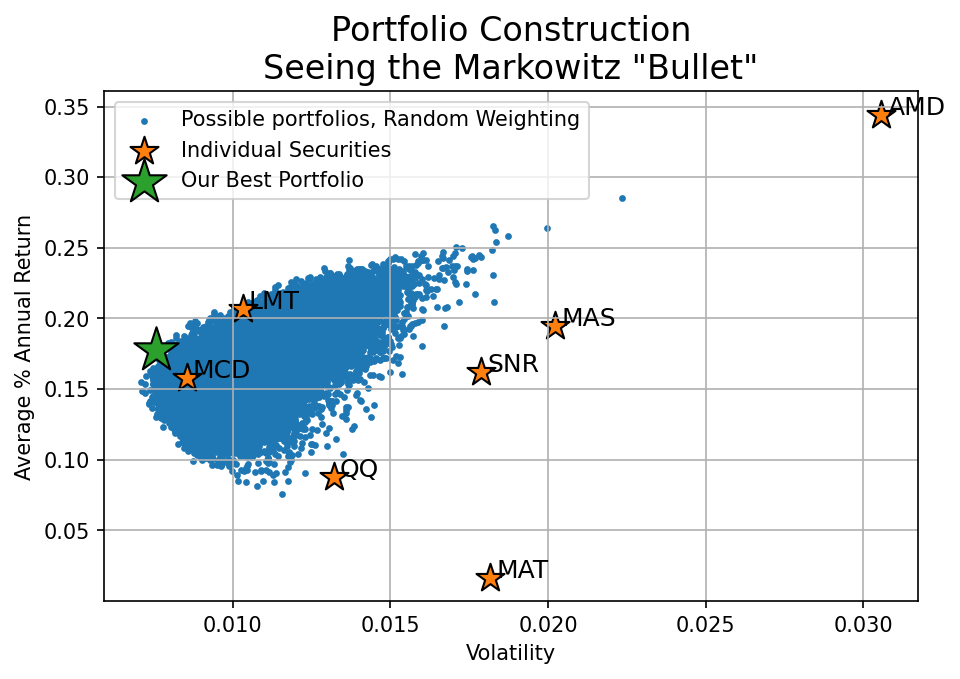

In [266]:
# Optimal Portfolio

# Find all the Sharpe Ratios
riskFreeReturn = 0.02
riskReturnAndPortfolios['SharpeRatio'] = \
    (riskReturnAndPortfolios['portfolioReturn'] - riskFreeReturn)/\
    riskReturnAndPortfolios['portfolioVolatility']

# Find the portfolio with the best Sharpe Ratio
bestPortfolioW = riskReturnAndPortfolios.loc[\
    riskReturnAndPortfolios['SharpeRatio'].idxmax()]['portfolioWeights']

# Find this portfolios return and volatility
bestPortfolioReturn = np.dot( (assets.iloc[-1] ** (1/10) - 1) , bestPortfolioW)
bestPortfolioVol = np.sqrt(calcPortfolioVar(assets, weights=bestPortfolioW))

print('The best portfolio we could find through random selection')
print('has a return of: ', round(bestPortfolioReturn,3),'%')
print('and a Volatility of: ', round(bestPortfolioVol,3))

# Plot best portfolio, random portfolios, as well as the individual stocks
plt.scatter(riskReturnAndPortfolios['portfolioVolatility'], 
            riskReturnAndPortfolios['portfolioReturn'], s=5)

plt.scatter(getVol(assets), 
            assets.iloc[-1] ** (1/10)-1, 
            marker='*', s=200, edgecolors='k')

plt.scatter(bestPortfolioVol, 
            bestPortfolioReturn, 
            marker='*', s=500, edgecolors='k')

plt.xlabel('Volatility');
plt.ylabel('Average % Annual Return');
plt.title('Portfolio Construction\nSeeing the Markowitz "Bullet"', fontsize=16);
plt.grid();
plt.legend(['Possible portfolios, Random Weighting', 
            'Individual Securities', 
            'Our Best Portfolio']);

# Plot the names of the individual stocks
for i in range(assets.shape[1]):
    x = volatility[i]
    y = returns[i]
    plt.text(x + 2e-4, y + 2e-4 , assets.keys()[i].upper(), fontsize=12)

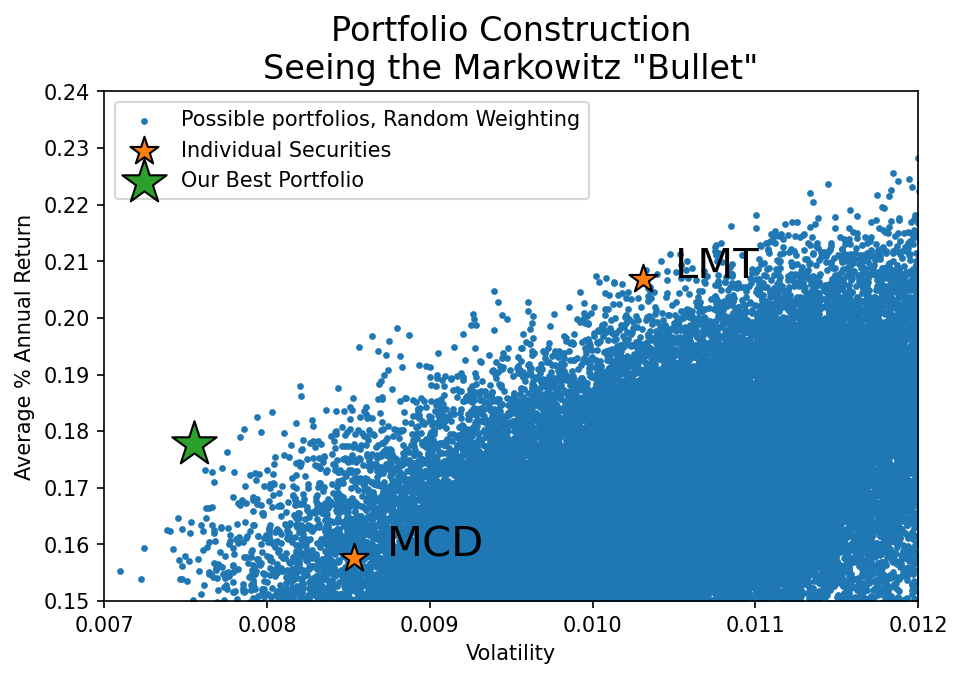

In [273]:
plt.scatter(riskReturnAndPortfolios['portfolioVolatility'], 
            riskReturnAndPortfolios['portfolioReturn'], s=5)

plt.scatter(getVol(assets), assets.iloc[-1] ** (1/10)-1, marker='*', s=200, edgecolors='k')
plt.scatter(bestPortfolioVol, bestPortfolioReturn, marker='*', s=500, edgecolors='k')
plt.xlabel('Volatility');
plt.ylabel('Average % Annual Return');
plt.title('Portfolio Construction\nSeeing the Markowitz "Bullet"', fontsize=16);
plt.grid();
plt.legend(['Possible portfolios, Random Weighting', 'Individual Securities', 'Our Best Portfolio']);

for i in range(assets.shape[1]):
    x = volatility[i]
    y = returns[i]
    if assets.keys()[i] in ['mcd','lmt']:
        plt.text(x + 2e-4, y + 2e-4 , assets.keys()[i].upper(), fontsize=20)
    
plt.xlim([0.007, 0.012])
plt.ylim([0.15, 0.24])
plt.grid();

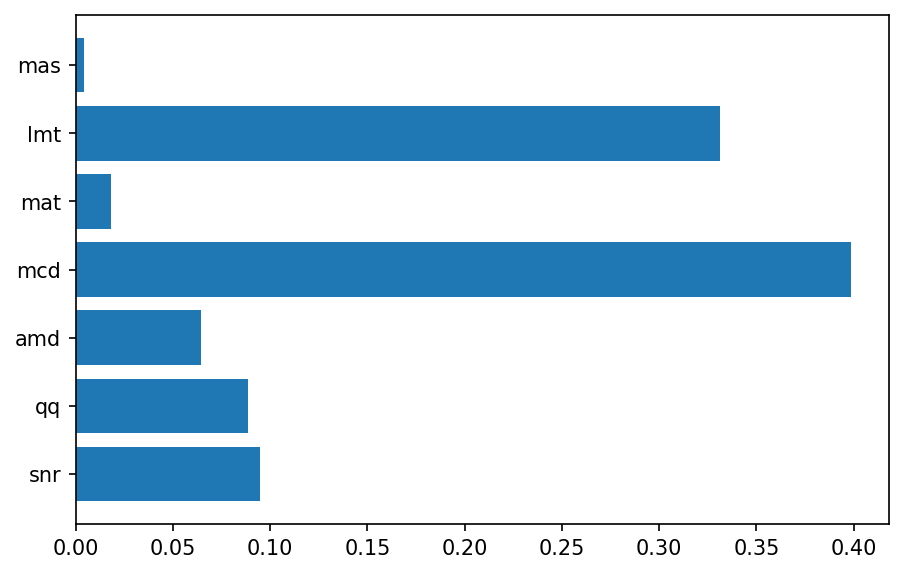

In [274]:
plt.barh(width=bestPortfolioW, y=assets.keys());

Text(0, 0.5, 'Relative Return')

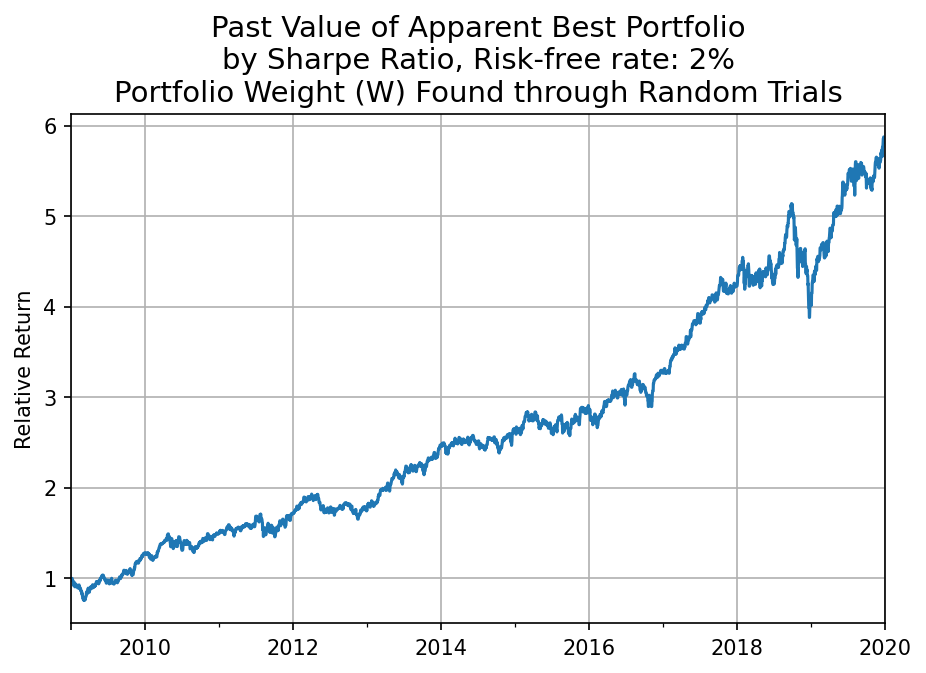

In [277]:
bestRandomPortfolio = (assets*bestPortfolioW).sum(axis=1)
bestRandomPortfolio.plot()
plt.grid()
plt.title('Past Value of Apparent Best Portfolio\nby Sharpe Ratio, Risk-free rate: 2%\nPortfolio Weight (W) Found through Random Trials', fontsize=14)
plt.ylabel('Relative Return')

Text(0, 0.5, 'Relative Return')

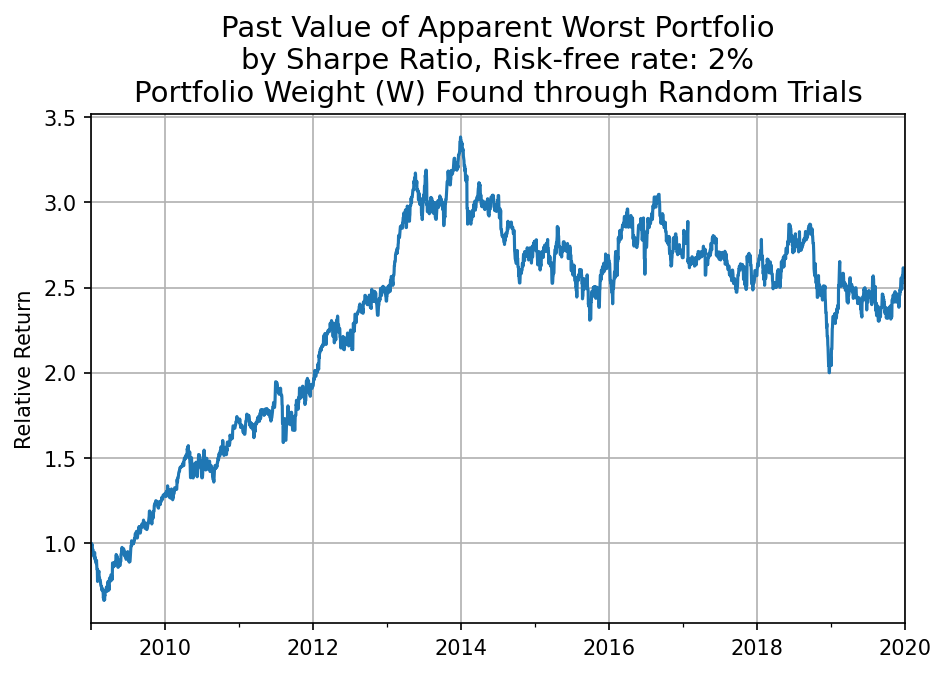

In [278]:
worstPortfolioW = \
riskReturnAndPortfolios.loc[riskReturnAndPortfolios['SharpeRatio'].idxmin()]['portfolioWeights']

worstRandomPortfolio = (assets*worstPortfolioW).sum(axis=1)
worstRandomPortfolio.plot()
plt.grid()
plt.title('Past Value of Apparent Worst Portfolio\nby Sharpe Ratio, Risk-free rate: 2%\nPortfolio Weight (W) Found through Random Trials', fontsize=14)
plt.ylabel('Relative Return')

In [37]:
plt.scatter(riskReturnAndPortfolios['portfolioVolatility'], 
            riskReturnAndPortfolios['portfolioReturn'], s=5)

plt.scatter(getVol(assets), assets.iloc[-1] ** (1/10)-1, marker='*', s=200, edgecolors='k')
plt.scatter(bestPortfolioVol, bestPortfolioReturn, marker='*', s=500, edgecolors='k')
plt.xlabel('Volatility');
plt.ylabel('Average % Annual Return');
plt.title('Portfolio Construction\nSeeing the Markowitz "Bullet"', fontsize=16);
plt.grid();
plt.legend(['Possible portfolios, Random Weighting', 'Individual Securities', 'Our Best Portfolio']);

for i in range(assets.shape[1]):
    x = volatility[i]
    y = returns[i]
    if assets.keys()[i] in ['mcd','lmt']:
        plt.text(x + 2e-4, y + 2e-4 , assets.keys()[i].upper(), fontsize=20)
    
plt.xlim([0.007, 0.012])
plt.ylim([0.15, 0.24])
plt.grid();

NameError: name 'riskReturnAndPortfolios' is not defined

The best portfolio we could find through random selection
has a return of:  0.236 %
and a Volatility of:  0.013


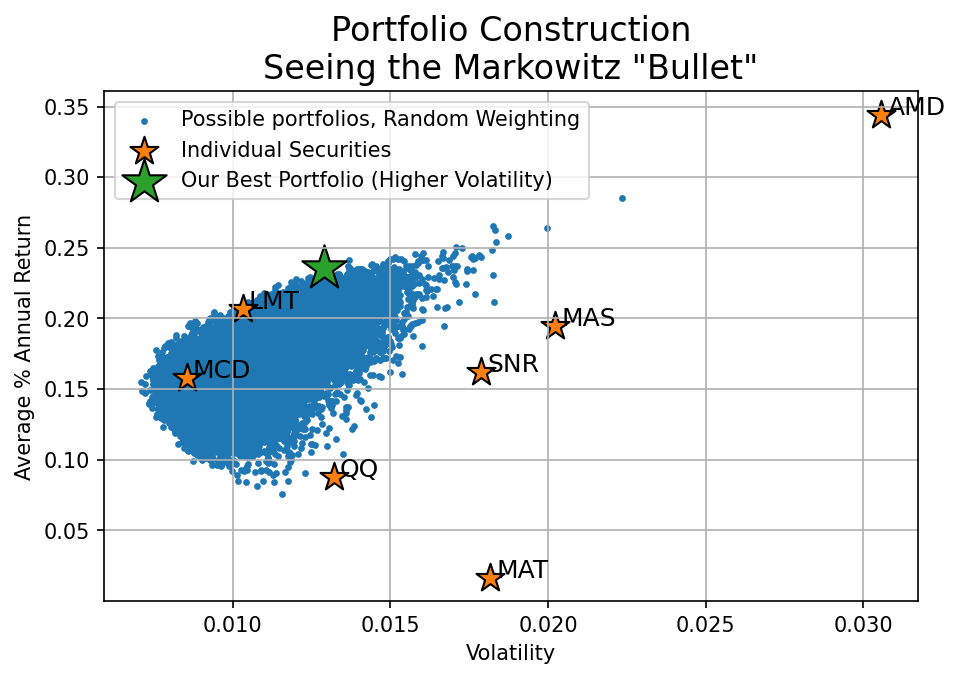

In [283]:
# Optimal Portfolio With different risk free return. 
# Ends up elsewhere on the efficient frontier

# Find all the Sharpe Ratios
riskFreeReturn = 0.14
riskReturnAndPortfolios['SharpeRatio'] = \
    (riskReturnAndPortfolios['portfolioReturn'] - riskFreeReturn)/\
    riskReturnAndPortfolios['portfolioVolatility']

# Find the portfolio with the best Sharpe Ratio
bestPortfolioW = riskReturnAndPortfolios.loc[\
    riskReturnAndPortfolios['SharpeRatio'].idxmax()]['portfolioWeights']

# Find this portfolios return and volatility
bestPortfolioReturn = np.dot( (assets.iloc[-1] ** (1/10) - 1) , bestPortfolioW)
bestPortfolioVol = np.sqrt(calcPortfolioVar(assets, weights=bestPortfolioW))

print('The best portfolio we could find through random selection')
print('has a return of: ', round(bestPortfolioReturn,3),'%')
print('and a Volatility of: ', round(bestPortfolioVol,3))

# Plot best portfolio, random portfolios, as well as the individual stocks
plt.scatter(riskReturnAndPortfolios['portfolioVolatility'], 
            riskReturnAndPortfolios['portfolioReturn'], s=5)

plt.scatter(getVol(assets), 
            assets.iloc[-1] ** (1/10)-1, 
            marker='*', s=200, edgecolors='k')

plt.scatter(bestPortfolioVol, 
            bestPortfolioReturn, 
            marker='*', s=500, edgecolors='k')

plt.xlabel('Volatility');
plt.ylabel('Average % Annual Return');
plt.title('Portfolio Construction\nSeeing the Markowitz "Bullet"', fontsize=16);
plt.grid();
plt.legend(['Possible portfolios, Random Weighting', 
            'Individual Securities', 
            'Our Best Portfolio']);

# Plot the names of the individual stocks
for i in range(assets.shape[1]):
    x = volatility[i]
    y = returns[i]
    plt.text(x + 2e-4, y + 2e-4 , assets.keys()[i].upper(), fontsize=12)

Text(0, 0.5, 'Relative Return')

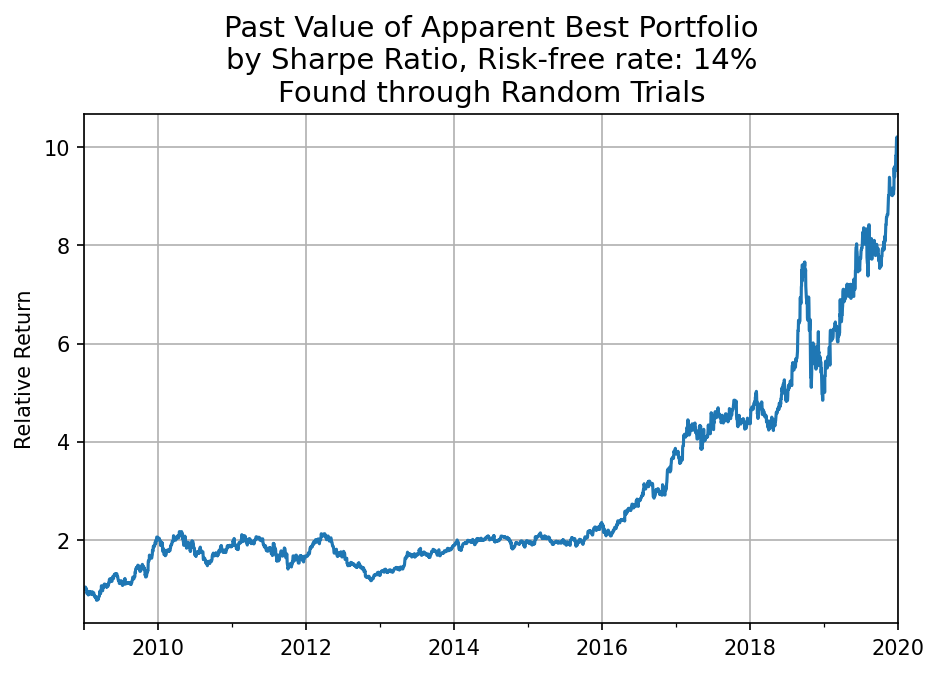

In [284]:
bestRandomPortfolio = (assets*bestPortfolioW).sum(axis=1)
bestRandomPortfolio.plot()
plt.grid()
plt.title('Past Value of Apparent Best Portfolio\nby Sharpe Ratio, Risk-free rate: 14%\nFound through Random Trials', fontsize=14)
plt.ylabel('Relative Return')

# Optimising the Portfolio Automatically

In [44]:
import scipy as sp
from scipy import optimize

def calcPortfolioVar(portfolio, weights=None):
    '''
    Input is portfolio price history DataFrame.
    Calculate the variance of the portfolio given the asset weighting.
    Assumes equal asset weighting if no weighting given.
    '''
    if weights is None:
        weights = [1 / portfolio.keys().size] * portfolio.keys().size
    
    #Calculate variance
    var = np.dot(np.dot(
                np.array(np.log(portfolio/portfolio.shift(-1)).cov()),
          weights),weights)
    
    return var

# Scipy has no maximize function, so invert Sharpe ratio and minimize.
def negativeSharpeRatio(weights, stockHistory, predReturns, risk_free_rate=0.05):
    '''
    Input DataFrame containing price history of all securities, also weighting,
    and the predicted returns for those securities.
    Calculates negative Sharpe Ratio.
    Assumes equal asset weighting if no weighting given.
    '''
    if weights is None: 
        weights = [1 / stockHistory.keys().size] * stockHistory.keys().size
    
    var = calcPortfolioVar(stockHistory, weights)
    portPredReturn = np.mean(predReturns * weights)
    return (risk_free_rate - portPredReturn) / np.sqrt(var) # negative

def optimisePortfolioMPT(stockHistory, predReturns, 
                         risk_free_rate=0.05, maxWeight=0.5):
    '''
    Use Markowitz portfolio optimisation to find the 'optimal' asset weighting.    
    By default the max. asset allocation is 50% of the portfolio.
    Use scipy.optimize to solve for asset allocation.
    https://docs.scipy.org/doc/scipy/reference/optimize.html
    https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html
    
    Markowitz, H.M. (March 1952). "Portfolio Selection". 
    The Journal of Finance. 7 (1): 77–91. doi:10.2307/2975974. JSTOR 2975974
    '''
    # Set the initial weights for the portfolio
    initialWeights = [1 / stockHistory.keys().size] * stockHistory.keys().size 
    
    # Set the bounds for each of the variables we will allow the solver to use
    # list of (0, 0.5) tuples
    bounds = [(0, maxWeight) for i in range(stockHistory.keys().size)] 
    
    # Set the constraint that the portfolio weights have to sum to one.
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Call the SciPy optimisation function
    results = sp.optimize.minimize(negativeSharpeRatio, 
                                   initialWeights, 
                                   (stockHistory, predReturns, risk_free_rate),
                                   method='trust-constr',#'SLSQP' or 'trust-constr'
                                   constraints=constraints,
                                   bounds=bounds#)
                            , options={'disp': True}) # To see the printout
    
    return results.x

C:\Users\G50\miniconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`gtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 200, CG iterations: 77, optimality: 8.14e-09, constraint violation: 1.11e-16, execution time: 0.65 s.


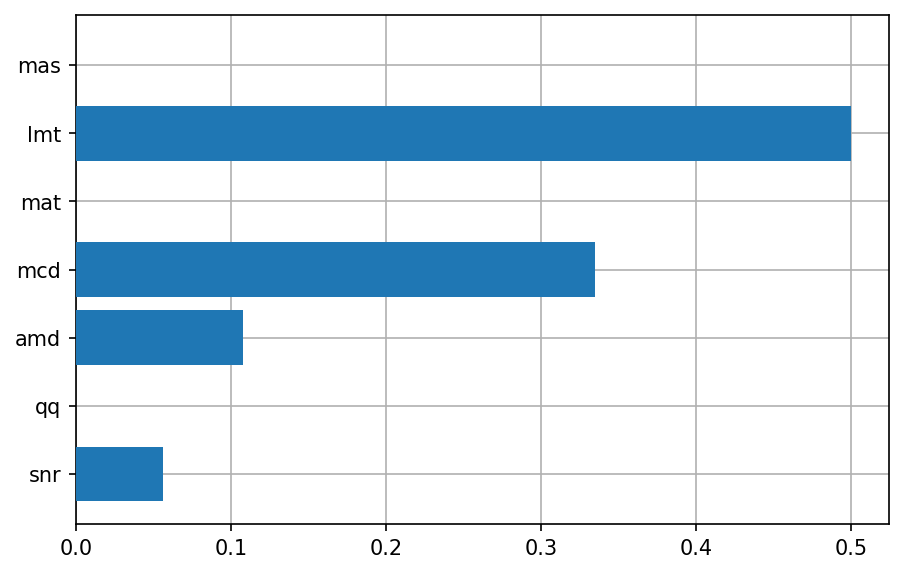

In [45]:
numYears = len(np.unique(assets.index.year)) # number of years

optimal_port = optimisePortfolioMPT(assets, 
                                    (assets.iloc[-1] ** (1/numYears) - 1), 
                                    risk_free_rate=0.01)

plt.barh(width=optimal_port, y=assets.keys(),zorder=3);
plt.grid(zorder=2)

<AxesSubplot:>

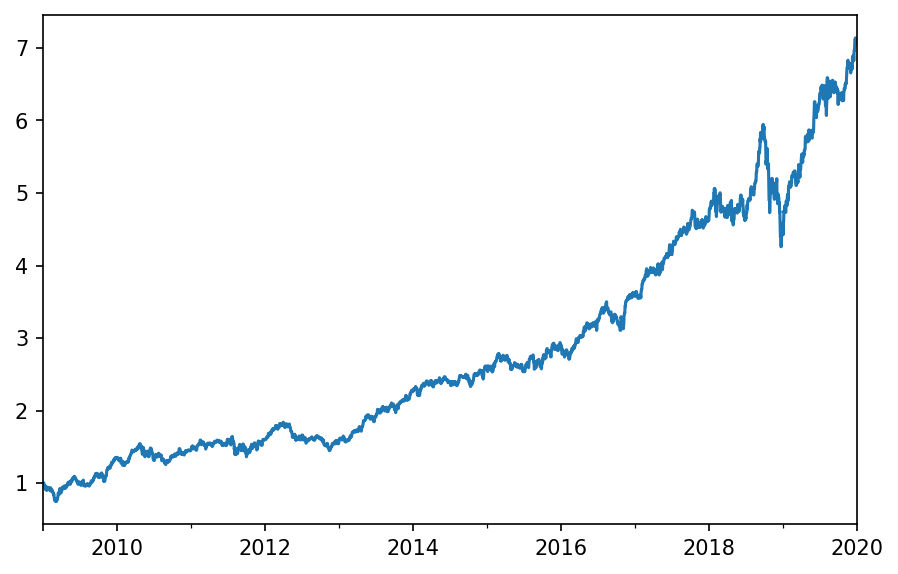

In [307]:
optimalPort = (assets * optimal_port).sum(axis=1)
optimalPort.plot()

The best portfolio we could find with SciPy Optimisation
has a return of:  20.3 %
and a Volatility of:  0.009


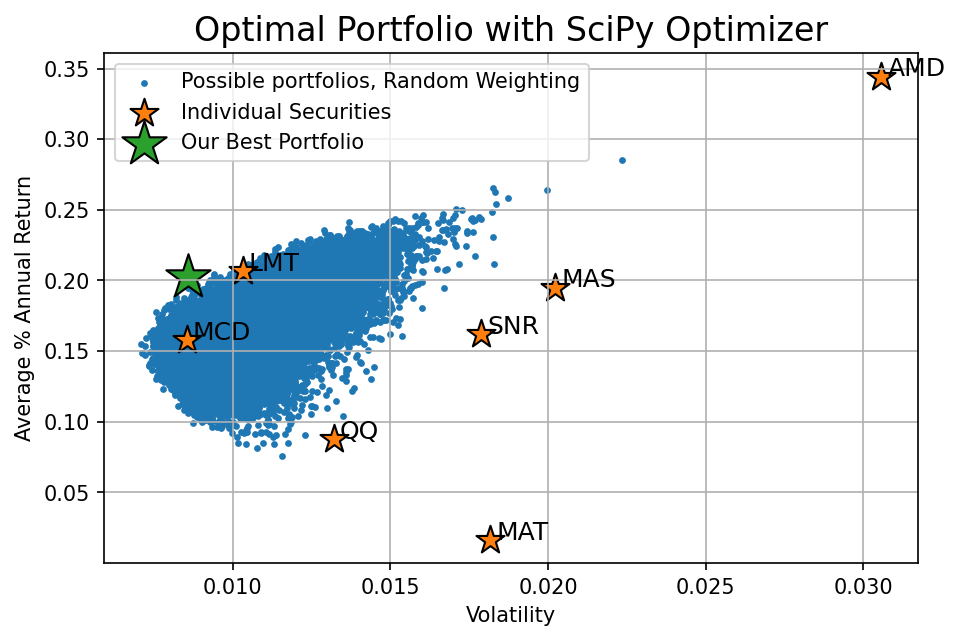

In [313]:
optimalPortfolioReturn = np.dot( (assets.iloc[-1] ** (1/10) - 1) , optimal_port)
optimalPortfolioVol = np.sqrt(calcPortfolioVar(assets, weights=optimal_port))

print('The best portfolio we could find with SciPy Optimisation')
print('has a return of: ', round(optimalPortfolioReturn, 3)*100, '%')
print('and a Volatility of: ', round(optimalPortfolioVol, 3))

plt.scatter(riskReturnAndPortfolios['portfolioVolatility'], 
            riskReturnAndPortfolios['portfolioReturn'], s=5)

plt.scatter(getVol(assets), 
            assets.iloc[-1] ** (1/10)-1, 
            marker='*', 
            s=200, 
            edgecolors='k')

plt.scatter(optimalPortfolioVol, 
            optimalPortfolioReturn, 
            marker='*', 
            s=500, 
            edgecolors='k')

plt.xlabel('Volatility');
plt.ylabel('Average % Annual Return');
plt.title('Optimal Portfolio with SciPy Optimizer', fontsize=16);
plt.grid();
plt.legend(['Possible portfolios, Random Weighting', 
            'Individual Securities', 
            'Our Best Portfolio']);

for i in range(assets.shape[1]):
    x = volatility[i]
    y = returns[i]
    plt.text(x + 2e-4, y + 2e-4 , assets.keys()[i].upper(), fontsize=12)

# MPT During a Market Crash

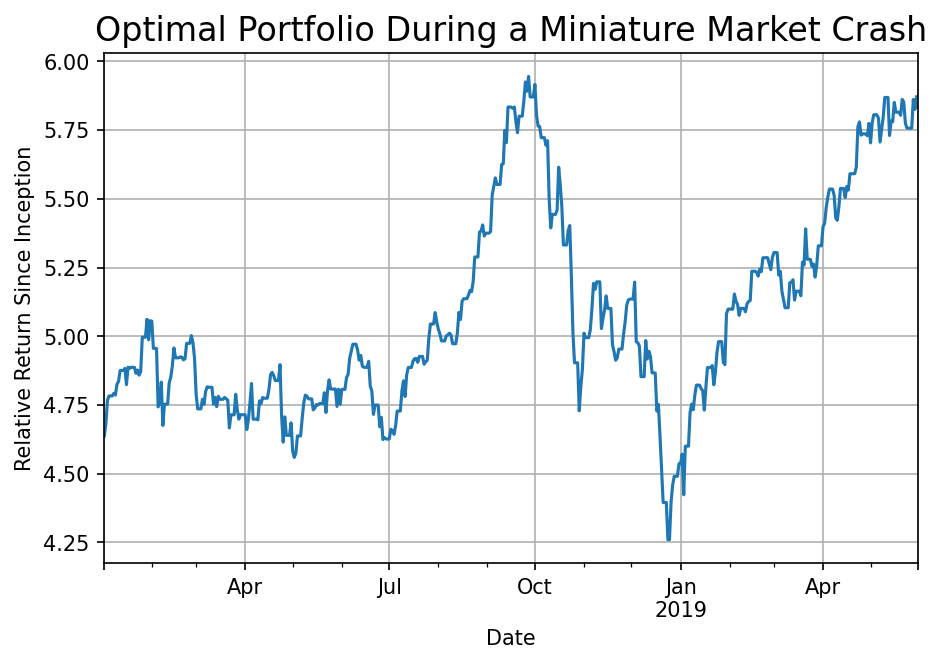

In [329]:
optimalPort[(optimalPort.index > '2018-01-01') & 
            (optimalPort.index < '2019-06-01')].plot()
plt.xlabel('Date');
plt.ylabel('Relative Return Since Inception');
plt.title('Optimal Portfolio During a Miniature Market Crash', fontsize=16);
plt.grid();

In [315]:
optimalPortbeforeCrash = assets[(assets.index < '2018-01-01')]\
                                [['lmt','mcd','amd','snr']]

np.log(optimalPortbeforeCrash/optimalPortbeforeCrash.shift(-1)).corr()

,lmt,mcd,amd,snr
lmt,1.000000,0.383242,0.222096,0.204071
mcd,0.383242,1.000000,0.243458,0.137561
amd,0.222096,0.243458,1.000000,0.155192
snr,0.204071,0.137561,0.155192,1.000000


In [316]:
optimalPortDuringCrash = assets[(assets.index > '2018-10-01') & 
                                (assets.index < '2019-06-01')]\
                                [['lmt','mcd','amd','snr']]

np.log(optimalPortDuringCrash/optimalPortDuringCrash.shift(-1)).corr()

,lmt,mcd,amd,snr
lmt,1.000000,0.344738,0.378013,0.121161
mcd,0.344738,1.000000,0.118746,-0.095072
amd,0.378013,0.118746,1.000000,0.333505
snr,0.121161,-0.095072,0.333505,1.000000


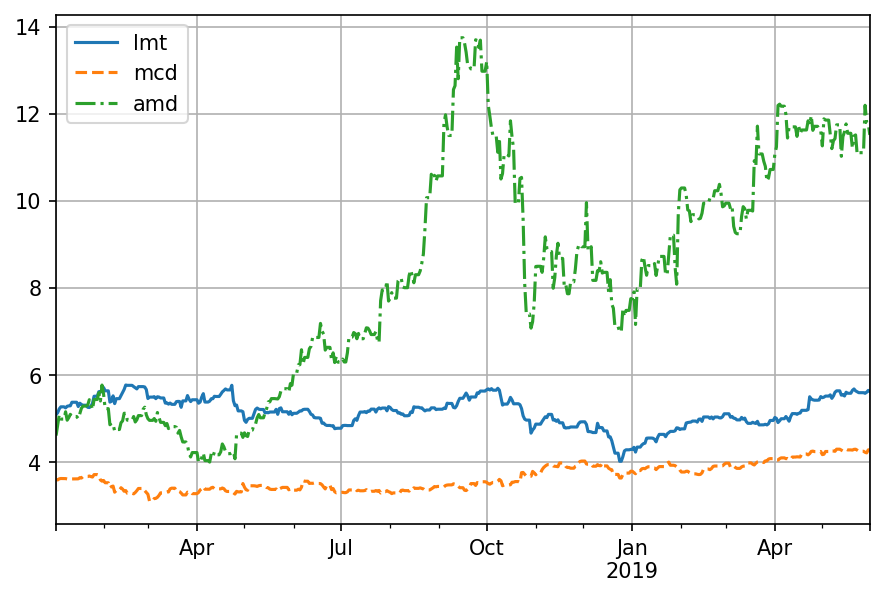

In [326]:
assets[(optimalPort.index > '2018-01-01') &
       (optimalPort.index < '2019-06-01')]\
        [['lmt','mcd','amd']].plot(style=['-','--','-.'])
plt.grid()